# HW9: Segmentation and Pose Estimation

Segmentation and pose estimation are among the coolest applications of computer vision.
Recently advanced in both these domains have brought big innovation in consumer products, from surveillence to broadcast media to fitness tracking to precision health and medical care.
We will implement basic versions, but the learnings are all the same!

In this exercise you will implement an image segmentation algorithm based on U-Net [Ronnenberger et al 2015](https://arxiv.org/abs/1505.04597) and a another segmentation algorithm based on [Xie et al 2021](https://proceedings.neurips.cc/paper/2021/file/64f1f27bf1b4ec22924fd0acb550c235-Paper.pdf) using attention networks.

Follow the cells below and complete the missing parts.

Good luck!

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import load_img, img_to_array
import keras

## Segmentation

In this part we will implement U-Net for segmentation. It is one of the greatest contributions in the field in the last 10 years and resulted in big innovations and impact.

U-Net is called so because of it's U shape encoder-decoder network architecture.

### Data Loading

First download the Oxford pets dataset with segmentation annotation.

Let's load the data and visualize a sample from it.

In [7]:
!curl -L -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -L -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz

!tar -xzf images.tar.gz
!tar -xzf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   187  100   187    0     0    502      0 --:--:-- --:--:-- --:--:--   505

  0  755M    0 48910    0     0  74392      0  2:57:25 --:--:--  2:57:25 74392
  0  755M    0 7455k    0     0  4312k      0  0:02:59  0:00:01  0:02:58 6916k
  2  755M    2 16.0M    0     0  5666k      0  0:02:16  0:00:02  0:02:14 7313k
  3  755M    3 26.0M    0     0  7299k      0  0:01:45  0:00:03  0:01:42 8882k
  4  755M    4 36.8M    0     0  8102k      0  0:01:35  0:00:04  0:01:31 9422k
  6  755M    6 45.7M    0     0  8278k      0  0:01:33  0:00:05  0:01:28 9356k
  6  755M    6 52.8M    0     0  8099k      0  0:01:35  0:00:06  0:01:29 9421k
  7  755M    7 57.9M    0     0  7748k      0  0:01:39  0:00:07  0:01:32 9012k
  8  755M    8 62.9M    0     0  7448k      0  0:0

In [ ]:
import os

# your input directory location may change, e.g. if you're on colab or a local machine
# make sure to adjust the paths below accordingly
input_dir = R"C:\Users\roysh\Downloads\images"
target_dir = R"C:\Users\roysh\Downloads\annotations\trimaps"
# on colab you can use e.g. the following:
# input_dir = "/content/images"
# target_dir = "/content/annotations/trimaps"

img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
C:\Users\roysh\Downloads\images\Abyssinian_1.jpg | C:\Users\roysh\Downloads\annotations\trimaps\Abyssinian_1.png
C:\Users\roysh\Downloads\images\Abyssinian_10.jpg | C:\Users\roysh\Downloads\annotations\trimaps\Abyssinian_10.png
C:\Users\roysh\Downloads\images\Abyssinian_100.jpg | C:\Users\roysh\Downloads\annotations\trimaps\Abyssinian_100.png
C:\Users\roysh\Downloads\images\Abyssinian_101.jpg | C:\Users\roysh\Downloads\annotations\trimaps\Abyssinian_101.png
C:\Users\roysh\Downloads\images\Abyssinian_102.jpg | C:\Users\roysh\Downloads\annotations\trimaps\Abyssinian_102.png
C:\Users\roysh\Downloads\images\Abyssinian_103.jpg | C:\Users\roysh\Downloads\annotations\trimaps\Abyssinian_103.png
C:\Users\roysh\Downloads\images\Abyssinian_104.jpg | C:\Users\roysh\Downloads\annotations\trimaps\Abyssinian_104.png
C:\Users\roysh\Downloads\images\Abyssinian_105.jpg | C:\Users\roysh\Downloads\annotations\trimaps\Abyssinian_105.png
C:\Users\roysh\Downloads\images\Abyssinian_106

Let's show a sample from the dataset:

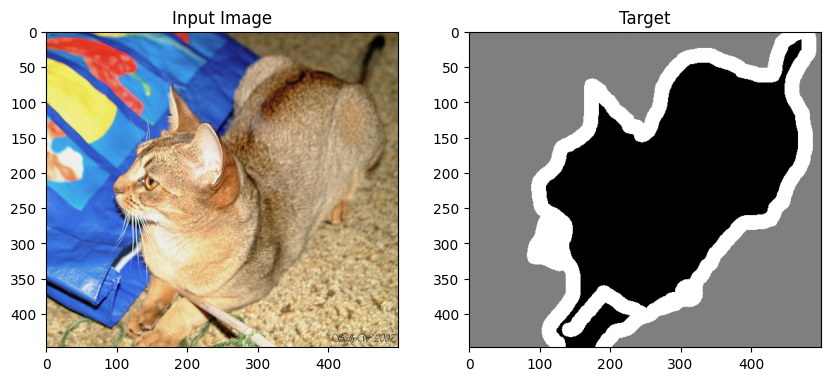

In [9]:
from IPython.display import display
from PIL import ImageOps
import matplotlib.pyplot as plt

# Load an input image
input_image = plt.imread(input_img_paths[9])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")

# Load and auto-contrast version of corresponding target (per-pixel categories)
target_image = ImageOps.autocontrast(load_img(target_img_paths[9]))
target_image = np.float32(img_to_array(target_image) / 255.0)

# Display auto-contrast version of corresponding target
plt.subplot(1, 2, 2)
plt.imshow(target_image)
plt.title("Target")
plt.show()


Let's build a TF Dataset to easily read the images and annotations

In [10]:
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

### Model Implementation

Let's build a simple U-Net model.

The model consists of a convolutional Encoder with 3 layers where each has stacked 2D seperable convolutions (they have less weights).

We will also add a residual connection - taking the output of the last layer, upsampling it, and adding it back to the output of the current layer.

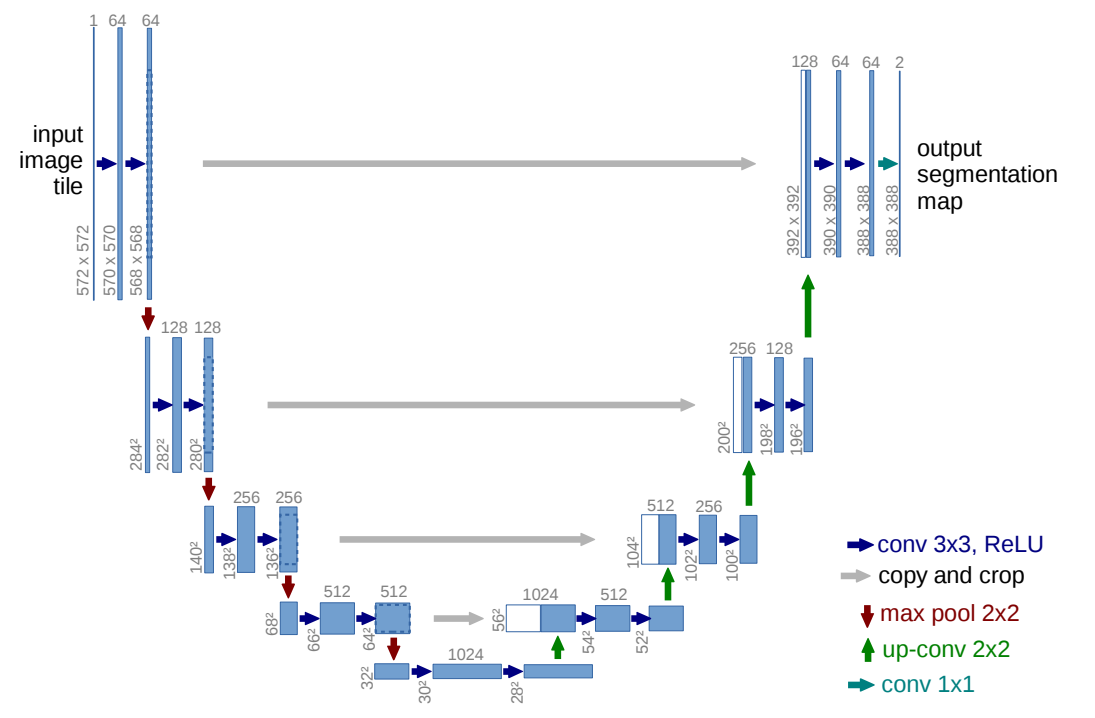

This follows [Ronnenberger et al](https://arxiv.org/pdf/1505.04597.pdf) closely.

In [ ]:
from keras import layers


def get_unet_model(img_size, num_classes):
    '''
    Builds the UNet model with MobileNetV2 encoder.
    Args:
        img_size: The input image size.
        num_classes: The number of output classes.

    Uses the following layers from keras:
        - keras.layers.Input
        - keras.layers.Conv2D
        - keras.layers.BatchNormalization
        - keras.layers.Activation
        - keras.layers.SeparableConv2D
        - keras.layers.MaxPooling2D
        - keras.layers.UpSampling2D
        - keras.layers.Concatenate
        - keras.layers.Conv2DTranspose
    
    Returns:
        The UNet model.
    '''

    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    # add a conv2d layer with 32 filters, 3x3 kernel size, padding "same", and stride of 2
    # use `layers.Conv2D`
    x = ...
    # add batch normalization using `layers.BatchNormalization`
    x = ...
    # add a relu activation using `layers.Activation` with "relu"
    x = ...

    previous_block_activation = x  # Set aside residual

    skip_connections = [x]

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        # add layers.Activation on top of previous block with "relu"
        x = ...
        # add a layers.SeparableConv2D layer with filters, 3x3 kernel size, and padding "same"
        x = ...
        # add batch normalization
        x = ...

        # add activation on top of previous block with "relu"
        x = ...
        # add a layers.SeparableConv2D layer with filters, 3x3 kernel size, and padding "same"
        x = ...
        # add batch normalization
        x = ...

        # save the outputs to be used in skip connections
        skip_connections.append(x)

        # add a layers.MaxPooling2D layer with pool size 3 and stride 2 and padding "same"
        x = ...

        # Project residual
        # add a layers.Conv2D layer with filters, 1x1 kernel size, and stride of 2, padding "same"
        # on top of previous_block_activation
        residual = ...
        # Add back `residual` to `x` with `layers.add()` 
        x = ...

        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for i, filters in enumerate( [256, 128, 64, 32]):
        if i > 0:
            # add `skip_connections[-i]` as input to this block
            # with `layers.Concatenate()` add the skip connection to `x`
            x = ...

        # add layers.Activation on top of previous block, with "relu"
        x = ...
        # add a layers.Conv2DTranspose layer with filters, 3x3 kernel size, and padding "same"
        x = ...
        # add batch normalization
        x = ...

        # add layers.Activation on top of previous block, with "relu"
        x = ...
        # add a layers.Conv2DTranspose layer with filters, 3x3 kernel size, and padding "same"
        x = ...
        # add batch normalization
        x = ...

        # add layers.UpSampling2D layer with size 2
        x = ...

        # Project residual
        # upsample (`layers.UpSampling2D`) the `previous_block_activation` with factor 2
        residual = ...
        # add a layers.Conv2D with filters, 1x1 kernel size, and padding "same"
        residual = ...

        # Add back residual to x like before with `layers.add()`
        x = ...

        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    # use a layers.Conv2D with num_classes filters, 3x3 kernel size, and padding "same"
    # with "softmax" activation, and num_classes as output depth (e.g. numebr of kernels)
    outputs = ...

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_unet_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,446,051 (9.33 MB)

 Trainable params: 2,442,275 (9.32 MB)

 Non-trainable params: 3,776 (14.75 KB)

### Prepare data for training

In [12]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

### Loss function

We're going to use a combined loss function that will take both pixel-classification and overall segmentation into account.

To do that, implement a cross-entropy loss for every pixel and add a Sørensen-Dice loss (akin to intersection over union).

$$
L_{\text{Dice}} = 1 - \frac{2 \sum_{i=1}^N p_i g_i}{\sum_{i=1}^N p_i^2 + \sum_{i=1}^N g_i^2}
$$

We're going to mix it with the built-in `keras.losses.SparseCategoricalCrossentropy()`.

In [ ]:
import tensorflow as tf
import keras.backend as K

@keras.saving.register_keras_serializable(name="CombinedCEAndDiceLoss")
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha

    def dice_loss(self, y_true, y_pred):
        smooth = K.epsilon()

        # Convert y_true to one-hot format with depth 3 (0, 1, 2)
        # use `tf.one_hot` after using `tf.cast` to convert y_true to int32
        # the `tf.one_hot` depth should be 3 for 3 classes
        y_true_one_hot = ...

        # Flatten the tensors
        # use `tf.reshape` to flatten both y_true_one_hot and y_pred to shape (-1, <num_classes>)
        y_true_f = ...
        y_pred_f = ...

        # Calculate Dice coefficient for each class
        # Intersection is the element-wise multiplication (`*`) of y_true_f and y_pred_f
        # use `tf.reduce_sum` to sum the intersection over all pixels
        # remember to use the `axis=0` argument to sum over all pixels
        intersection = ...
        # Union is the element-wise sum (`+`) of true and predicted pixels for each class
        # again use `tf.reduce_sum` to sum the union over all pixels (remember `axis=0`)
        union = ...

        # Calculate Dice coefficient for each class:
        # (2 * intersection + smooth) / (union + smooth)
        dice = ...

        # Dice loss for multi-class, averaged over all classes
        # remember to use 1 - mean(dice) as the dice loss
        # use `tf.reduce_mean` on `dice` to average over all classes
        dice_loss = ...

        return dice_loss

    def ce_loss(self, y_true, y_pred):
        # y_true is a 4D int8 tensor with shape (batch_size, height, width, 1)
        # y_pred is a 4D int8 tensor with shape (batch_size, height, width, num_classes)
        # use `keras.losses.SparseCategoricalCrossentropy()` loss with y_true and y_pred
        cross_entropy = ...
        return cross_entropy(y_true, y_pred)

    def call(self, y_true, y_pred):
        # Calculate the combined loss
        # use self.alpha to weight the `self.dice_loss()` and `self.ce_loss()` losses.
        # call the `self.dice_loss()` and `self.ce_loss()` functions with y_true and y_pred.
        # return the combined loss
        return ...

### Model training

Compile the model and run training for 30-50 epochs.

In [14]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=CombinedLoss())

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/30
32/32 - 32s - 1s/step - loss: 1.0066 - val_loss: 1.0180
Epoch 2/30
32/32 - 23s - 734ms/step - loss: 0.6714 - val_loss: 1.1859
Epoch 3/30
32/32 - 24s - 740ms/step - loss: 0.5981 - val_loss: 1.6022
Epoch 4/30
32/32 - 22s - 699ms/step - loss: 0.5563 - val_loss: 1.9948
Epoch 5/30
32/32 - 22s - 676ms/step - loss: 0.5248 - val_loss: 2.3515
Epoch 6/30
32/32 - 22s - 675ms/step - loss: 0.4961 - val_loss: 2.6929
Epoch 7/30
32/32 - 22s - 673ms/step - loss: 0.4684 - val_loss: 3.0651
Epoch 8/30
32/32 - 22s - 680ms/step - loss: 0.4424 - val_loss: 3.4968
Epoch 9/30
32/32 - 21s - 671ms/step - loss: 0.4175 - val_loss: 3.9866
Epoch 10/30
32/32 - 22s - 686ms/step - loss: 0.3930 - val_loss: 4.4999
Epoch 11/30
32/32 - 21s - 672ms/step - loss: 0.3691 - val_loss: 4.9596
Epoch 12/30
32/32 - 23s - 714ms/step - loss: 0.3465 - val_loss: 5.3199
Epoch 13/30
32/32 - 23s - 713ms/step - loss: 0.3250 - val_loss: 5.5515
Epoch 14/30
32/32 - 22s - 681ms/step - loss: 0.3060 - val_loss: 5.5138
Epoch 15/30
32/32 

### Prediction and Results analysis

Let's predict some outputs from the validation set and reason about the results.

In [89]:
# Generate predictions for all images in the validation set
val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step


Visualize the predictions

In [ ]:
from matplotlib import pyplot as plt
from PIL import ImageOps

def get_mask(val_preds_, i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds_[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    return img

def display_results(val_input_img_paths_, val_target_img_paths_, val_preds_):
    # Display results for validation for 10 images
    plt.figure(figsize=(20, 8))

    for i in range(10):
        plt.subplot(3, 10, i + 1)
        plt.title("Input image")
        plt.axis("off")
        plt.imshow(keras.utils.load_img(val_input_img_paths_[i]))

        # Display ground-truth target mask
        img = ImageOps.autocontrast(keras.utils.load_img(val_target_img_paths_[i]))
        plt.subplot(3, 10, i + 11)
        plt.title("GT mask")
        plt.axis("off")
        plt.imshow(img)

        # Display mask predicted by our model
        plt.subplot(3, 10, i + 21)
        plt.title("Pred mask")
        plt.axis("off")
        plt.imshow(get_mask(val_preds_, i))


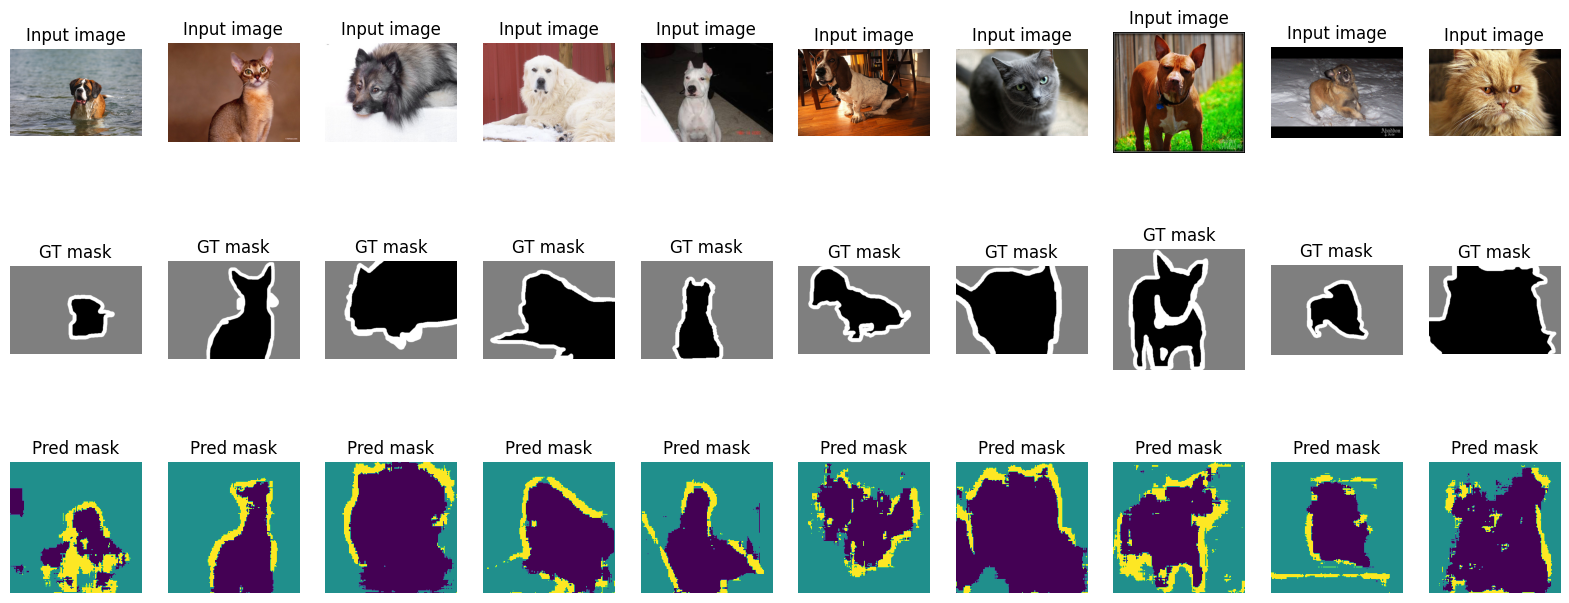

In [90]:
# display the results
display_results(val_input_img_paths, val_target_img_paths, val_preds)

We're starting to see good predictive behaviour on the held-out validation set, which is very promising.

To turn this into a real performant network we likely need more training time, a bigger network, and more data of course.

But I would say this is a pretty good first step! Congratulations on implementing a working segmentation network!

## Segmentation with Transformers

In this part we will implement a transformer network from multi-head self attention blocks, following the seminal paper "SegFormer: Simple and efficient design for semantic segmentation with transformers" [Xie et al 2021](https://proceedings.neurips.cc/paper/2021/file/64f1f27bf1b4ec22924fd0acb550c235-Paper.pdf).

SegFormer was a pivotal moment in image segmentation since it was the first major implementation of transformers for segmentation that was widely successful and adopted.

Compared to other leading CNN segmetation algorithms of the time (like DeepLabV3 and HRNet), Segformer was both much smaller and also more performant.

The architecture of the Segformer network is straightforward:

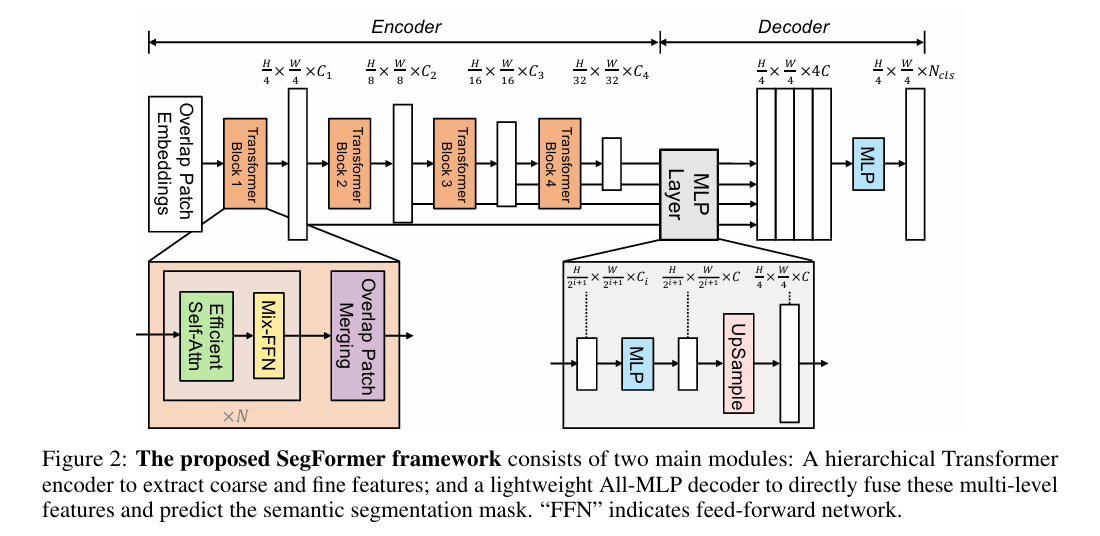

For the transformer block it uses self attention layers (with a twist called "Efficient Self Attention"), a feed forward network and then a layer called "Overlap Path Merging" which is implemented with a convolutional layer. 

Notice that the bulk of the work is done by the transformer Encoder and the network only has a small Decoder based on MLP. As we've discussed in class, we don't always need a transformer Decoder, it all depends on the task at hand. In case of segmentation - we can do just fine with a minimal fully connected network.

The SegFormer, while a powerful algoritm, is not an overly difficult network to implement, so let's get to work!

---

First let's build the layers.

Starting from the MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    '''
    Create a multi-layer perceptron (MLP) for the model.

    Args:
    x: input tensor
    hidden_units: a list of integers (e.g. [10, 20, 50]), specifying the number of units in each MLP layer
    dropout_rate: dropout rate between layers

    To implement the MLP, you will need to use the following Keras layers:
    - layers.Dense: add a dense layer
    - layers.Dropout: apply dropout to the layer

    Use the following parameter for all layers:
    - activation: tf.nn.gelu

    You should use a for loop to create multiple layers, and you should use the hidden_units argument to determine the number of layers.

    Return the output tensor
    '''
    input_dim = x.shape[-1]
    for units in hidden_units:
        # add a dense layer with `units` and activation "gelu" (or tf.nn.gelu)
        x = ...
        # add dropout with `dropout_rate`
        x = ...
    # return an output layers.Dense with `input_dim`
    return ...


SegFormer suggested a new method for extracting and handling image patches. Not only do they use 4x4 sized patches (where ViT used 16x16), they also propose a new "Overlapped Patch Merging" layer:

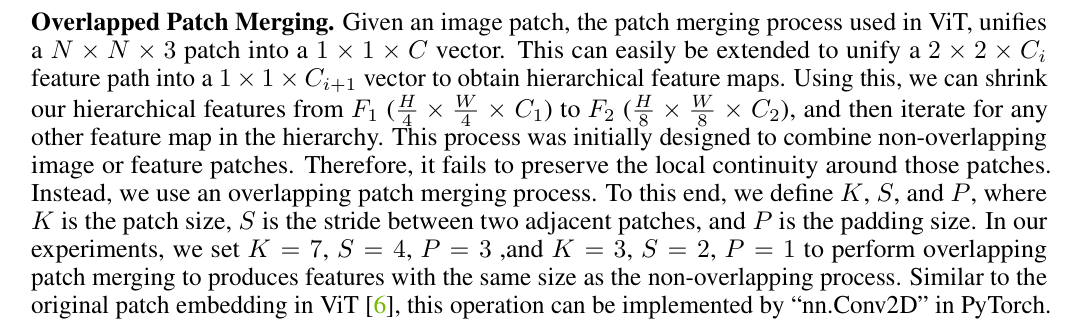

The essence being that if we simple separate the image to non overlapping patches - we miss out on an opportunity to encode the continuity in the overlaps between patches (which does not happen in ViT). Fortunately, all this means is that we use a strided convlution layer.

In [ ]:
def overlap_patch_embed(x, patch_size, stride, num_patches):
    '''Create an overlapping patch embedding layer

    Args:
    x: input tensor
    patch_size: the size of the patch
    stride: the stride of the patch
    num_patches: the number of patches

    To implement the overlapping patch embedding, you will need to use the following Keras layers:
    - layers.Conv2D: add a convolutional layer
    - layers.LayerNormalization: add layer normalization

    Use the following parameter for the convolution layer:
    - kernel_size: patch_size
    - strides: stride
    - padding: "same"
    - epsilon: 1e-6

    Return the output tensor
    '''
    # add a layers.Conv2D with `num_patches` filters, `patch_size` kernel size, `stride` strides, and padding "same"
    x = ...
    # add a layers.LayerNormalization with epsilon=1e-6
    x = ...
    return x


Perhaps the most interesting innovation in SegFormer is the Efficient Self-Attention. It points out that vanilla self-attention has high dimensionality in high resolution images because it computes similarity between all input tokens. The complexity of S.A. is O(N^2) and where N is large (a lot of image patches) it's expensinve. They suggest to reduce the input by a large amount (e.g. R=64) for the first stage of the transformer, and lower until R=1 for the later stages.

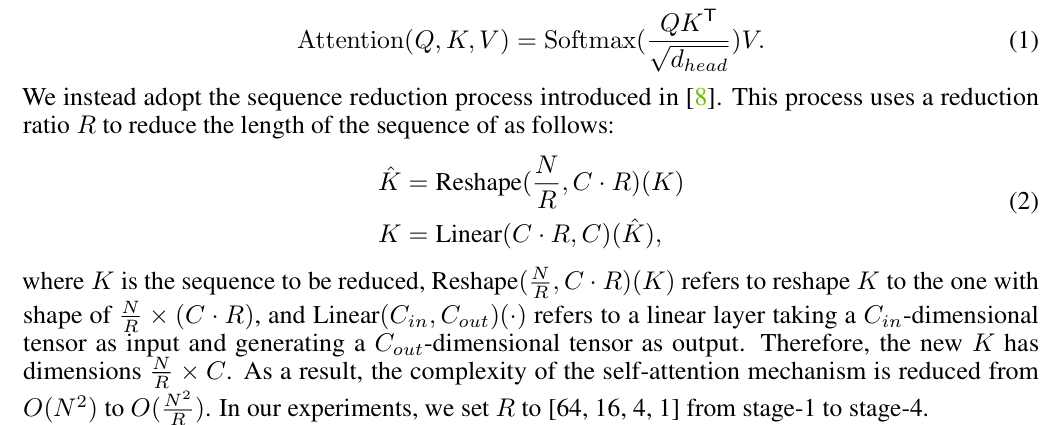

In [ ]:
from keras import ops

def efficient_self_attention(x, num_heads, projection_dim):
    '''Create an efficient self-attention layer

    Args:
    x: input tensor
    num_heads: number of attention heads
    projection_dim: the projection dimension

    To implement the efficient self-attention, you will need to use the following Keras layers and functions:
    - layers.Dense: add a dense layer
    - layers.Reshape: reshape the tensor
    - layers.Permute: permute the tensor
    - ops.shape: get the shape of the input tensor
    - ops.transpose: transpose the tensor
    - ops.reshape: reshape the tensor
    - ops.matmul: matrix multiplication
    - ops.nn.softmax: apply softmax activation

    Use the following parameter for all layers:
    - activation: None

    You should use the num_heads argument to determine the number
    of attention heads and the projection_dim argument to determine the projection dimension.

    Return the output tensor
    '''
    batch_size = x.shape[0]
    height = x.shape[1]
    width = x.shape[2]
    channels = x.shape[3]
    
    # as we are using the efficient self-attention mechanism, we need to reshape the input tensor
    # to have the same number of channels as the projection dimension.
    # we achieve this by adding a layers.Dense with the projection dimension (`projection_dim`).
    # we need do this for the query, key, and value tensors.
    q = ...
    k = ...
    v = ...
    
    # reshape (ops.reshape) the query, key, and value tensors into multiple heads
    # the shape of the tensors should be (height * width, num_heads, projection_dim // num_heads)
    q = ...
    k = ...
    v = ...

    # now we need to transpose the query, key, and value tensors because we want to perform
    # the self-attention operation on the last two dimensions (height, width).
    # therefore, we need to move the num_heads dimension to the front, e.g. (num_heads, batch_size, height, width, projection_dim // num_heads)
    # use `layers.Permute` to achieve this with the correct permutation of axes, e.g. (2, 1, 3) (the batch_size dimension is neglected in layers.Permute).
    q = ...
    k = ...
    v = ...

    # calculate the attention scores by performing a matrix multiplication between the query and key tensors
    # then divide the result by the square root of the projection dimension divided by the number of heads,
    # (projection_dim // num_heads). This is a common scaling factor used in self-attention mechanisms
    # as the attention scores are sensitive to the scale of the projection dimension.
    # finally, apply the softmax activation to the result.
    # first we need to `ops.transpose` the key tensor to have the correct shape for the matrix multiplication ([0, 1, 3, 2]).
    k_transposed = ...
    # calculate the attention scores with the query (`q`) and transposed key tensors (`k_transposed`) using `ops.matmul`
    attn = ...
    # divide the result `attn` by the `ops.sqrt` of the `projection_dim // num_heads` (casted to "float32"!)
    attn = ...
    # apply the `ops.softmax` activation to the result (add axis=-1 to apply softmax on the last dimension)
    attn = ...
    # now we have the attention scores, we can calculate the weighted sum of the value tensor using the attention scores.
    # this is done by performing a matrix multiplication (ops.matmul) between the attention scores `attn` and the value tensor `v`.
    out = ...
    
    # calculate the weighted sum of the value tensor using the attention scores.
    # this is done by performing a matrix multiplication (ops.matmul) between the attention scores and the value tensor.
    # the result is the output of the self-attention mechanism.
    # remember to transpose the attention scores to have the same shape as the value tensor.
    # to do this use ops.transpose with the correct permutation of axes and then ops.reshape the result
    # into the orignal shape (batch_size, height, width, channels).
    # use `ops.matmul` to calculate the weighted sum of the value tensor `v` and the attention scores `attn`.
    out = ...
    # `ops.transpose` the result to have the same shape as the value tensor e.g [0, 2, 1, 3]
    out = ...
    # `ops.reshape` the result to have the same shape as the input tensor e.g. (-1, height, width, projection_dim)
    out = ...
    
    # finally, we need to add a layers.Dense with the original number of channels to project the output tensor
    return layers.Dense(channels)(out)


Let's assemble the transformer block's self-attention and MLP portion, which is applied several times (notice the $\times N$ in the diagram). The overlap patch embedding will be applied outside of this.

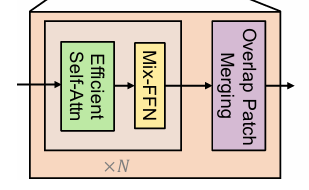

In [ ]:
def transformer_block(x, num_heads, projection_dim, mlp_units, dropout_rate=0.1):
    '''Create a transformer block

    Args:
    x: input tensor
    num_heads: number of attention heads
    projection_dim: the projection dimension
    mlp_units: a list of integers (e.g. [10, 20, 50]), specifying the number of units in each MLP layer
    dropout_rate: dropout rate between layers

    To implement the transformer block, you will need to use the following Keras layers and functions:
    - layers.LayerNormalization: add layer normalization
    - efficient_self_attention: use the efficient self-attention layer
    - mlp: use the multi-layer perceptron

    Return the output tensor
    '''
    # keep the input tensor to be used in the residual connection
    residual_1 = x
    # add layers.LayerNormalization, then apply the efficient self-attention layer (`efficient_self_attention()`) with the given arguments
    # (num_heads, projection_dim), then add layers.Dropout with the dropout rate.
    # use `layers.LayerNormalization` with epsilon=1e-6
    x = ...
    # apply the `efficient_self_attention()` layer with the given arguments (num_heads, projection_dim)
    x = ...
    # add layers.Dropout with the given dropout rate
    x = ...
    # `layers.Add` the `residual_1` connection back to the input tensor
    x = ...
    
    # keep the output tensor to be used in the residual connection
    residual_2 = x
    # add layers.LayerNormalization, then apply the multi-layer perceptron (e.g. `mlp()`) with the given arguments
    # (mlp_units, dropout_rate)
    x = ...
    x = ...
    
    # `layers.Add` the residual connection back to the output tensor
    x = ...
    
    return x


Finally let's put everything together for the SegFormer network.

In [ ]:
def create_segformer(
    input_shape,
    num_classes,
    patch_sizes=[7, 3, 3, 3],
    strides=[4, 2, 2, 2],
    num_blocks=[2, 2, 2, 2],
    projection_dims=[64, 128, 256, 512],
    num_heads=[1, 2, 4, 8],
    mlp_ratios=[4, 4, 4, 4],
    decoder_projection_dim=256,
    decoder_mlp_units=[128, 64],
    dropout_rate=0.1,
):
    '''Create a Segformer model

    Args:
    input_shape: tuple, the input shape of the model
    num_classes: int, the number of output classes
    patch_sizes: list of integers, the size of the patches
    strides: list of integers, the stride of the patches
    num_blocks: list of integers, the number of transformer blocks
    projection_dims: list of integers, the projection dimension of the patches
    num_heads: list of integers, the number of attention heads
    mlp_ratios: list of integers, the ratio of units in the MLP
    decoder_projection_dim: int, the projection dimension of the decoder
    decoder_mlp_units: list of integers, the number of units in each decoder MLP layer
    dropout_rate: float, dropout rate between layers

    To implement the Segformer model, you will need to use the following functions:
    - layers.Input: create an input layer
    - overlap_patch_embed: create an overlapping patch embedding layer
    - transformer_block: create a transformer block
    - layers.Concatenate: concatenate the encoder and decoder outputs
    - layers.Conv2D: add a convolutional layer
    - layers.LayerNormalization: add layer normalization
    - layers.Dropout: apply dropout to the layer
    - ops.image.resize: resize the image
    - ops.shape: get the shape of the tensor

    Return the Keras model
    '''

    # create the input layer
    inputs = keras.Input(shape=input_shape)
    
    # Encoder
    x = inputs
    encoder_outputs = []
    
    # we have multiple stages in the Segformer model, each stage has a different patch size, stride, number of patches,
    # projection dimension, number of heads, and MLP ratio.
    for stage_idx in range(len(patch_sizes)):
        # in each stage of the encoder, we apply the overlapping patch embedding layer
        # then we apply multiple transformer blocks

        # apply the overlapping patch embedding (`overlap_patch_embed(x, ...)`) layer with the given arguments, e.g.
        # patch_size=patch_sizes[stage_idx], stride=strides[stage_idx], num_patches=projection_dims[stage_idx]
        x = ...
        
        # apply multiple transformer blocks (`transformer_block(x, ...)`) with the given arguments, e.g.
        # num_blocks=num_blocks[stage_idx], num_heads=num_heads[stage_idx], projection_dim=projection_dims[stage_idx],
        # mlp_units=[projection_dims[stage_idx] * mlp_ratios[stage_idx]], dropout_rate=dropout_rate
        for _ in range(num_blocks[stage_idx]):
            x = ...
        
        # save the output of the encoder stage to be used in the decoder
        encoder_outputs.append(x)
    
    # Decoder
    decoder_output = None
    for encoder_output in encoder_outputs:
        if decoder_output is None:
            decoder_output = encoder_output
        else:
            # upsample decoder output to match current encoder output.
            # resize the decoder output to have the same height and width as the encoder output.
            # use `ops.shape` to get the shape of the encoder output and resize the decoder output to match it.
            target_shape = ops.shape(encoder_output)[1:3]
            # use `ops.image.resize` to resize the `decoder_output` to `target_shape`
            decoder_output = ...
            # then `layers.Concatenate` the `encoder_output` with the `decoder_output`
            decoder_output = ...
    
    # Final MLP head
    # apply a `layers.Conv2D` layer with the decoder_projection_dimension and 1x1 kernel size
    decoder_output = ...
    # apply layer normalization with epsilon=1e-6
    decoder_output = ...
    
    # apply multiple MLP layers. use the decoder_mlp_units argument to determine the number of units in each layer
    # and the dropout_rate argument for the dropout rate between layers.
    for units in decoder_mlp_units:
        # add a `layers.Conv2D` layer with units, 1x1 kernel size, and activation=tf.nn.gelu
        decoder_output = ...
        # add a `layers.Dropout` layer with the dropout_rate
        decoder_output = ...
    
    # Upsample to original size
    decoder_output = ops.image.resize(
        decoder_output,
        ops.shape(inputs)[1:3],
        interpolation="bilinear",
    )
    
    # Final classification head
    # apply a `layers.Conv2D` layer with num_classes and 1x1 kernel size, and activation="softmax"
    outputs = ...
    
    return keras.Model(inputs, outputs)


In [ ]:
# Example model parameters:
def create_example_segformer_model():
    model = create_segformer(
        input_shape=(160, 160, 3),
        num_classes=3,  # BG, FG, boundary
        patch_sizes=[7, 3, 3, 3],
        strides=[4, 2, 2, 2],
        num_blocks=[2, 2, 2, 2],
        projection_dims=[64, 128, 256, 512],
        num_heads=[1, 2, 4, 8],
        mlp_ratios=[4, 4, 4, 4],
        decoder_projection_dim=256,
        decoder_mlp_units=[128, 64],
        dropout_rate=0.1,
    )
    return model

In [ ]:
# Training function
# We're using the same training function as before, this time with the Segformer model.
# for the loss function we're going to use the built-in SparseCategoricalCrossentropy loss.
# But you can also use the CombinedLoss function we created earlier!
def train_segformer_model(model, train_dataset, validation_dataset, epochs=50):
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-4,
            weight_decay=1e-4
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=5,
                restore_best_weights=True
            )
        ]
    )

In [83]:
segformer_model = create_example_segformer_model()

In [86]:
train_segformer_model(
    segformer_model,
    train_dataset,
    valid_dataset,
    epochs=30
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.4999 - loss: 1.1062 - val_accuracy: 0.5840 - val_loss: 0.8989
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5828 - loss: 0.9025 - val_accuracy: 0.5840 - val_loss: 0.8854
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5809 - loss: 0.8898 - val_accuracy: 0.5840 - val_loss: 0.8863
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5840 - loss: 0.8874 - val_accuracy: 0.5832 - val_loss: 0.8847
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5830 - loss: 0.8856 - val_accuracy: 0.5832 - val_loss: 0.8834
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5833 - loss: 0.8833 - val_accuracy: 0.5831 - val_loss: 0.8794
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5891 - loss: 0.8788 - val_accuracy: 0.6321 - val_loss: 0.8561
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6186 - loss: 0.8558 - val_accuracy: 0.6833 - val_loss:

In [91]:
# Generate predictions for all images in the validation set
val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
segformer_val_preds = segformer_model.predict(val_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step


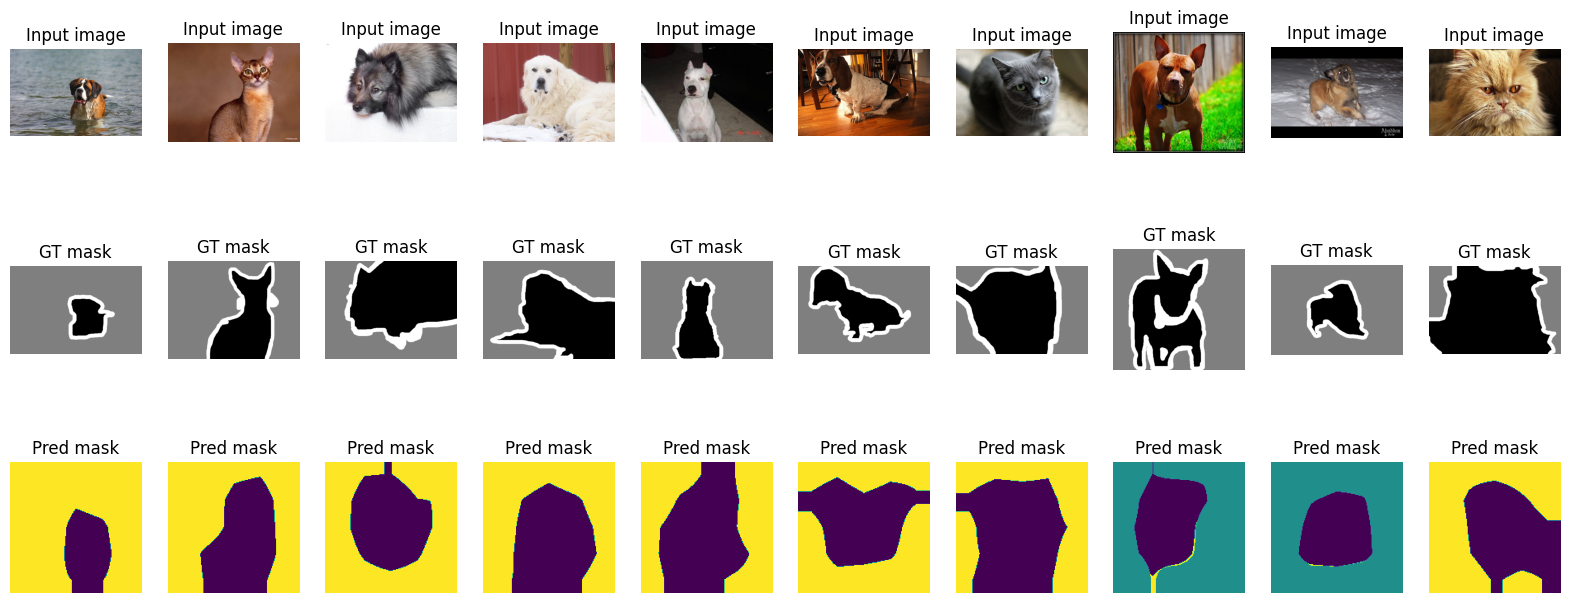

In [92]:
# display the results
display_results(val_input_img_paths, val_target_img_paths, segformer_val_preds)

Looks like SegFormer needs much more training! And could benefit from applying a different loss function. But this was expected! Since the model is indeed much larger than the UNet from before.
Feel free to let the model traing for much longer, like 100 epochs.

Neverthe less, the model is definitely learning how to segment the images with the attention mechanisms we implemented.

That's a wrap!

Thanks for playing everyone.